![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center> PREDICCIÓN DE LA DUREZA DE MOH</center>


## IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold

from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import  train_test_split, cross_val_score
from sklearn.metrics import make_scorer, median_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

## DATASET

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Nestorbd/Prediction-of-Mohs-Hardness/master/Mineral_Dataset_Supplementary_Info.csv").drop('Unnamed: 0', axis=1)
target = df.pop("Hardness")
df.insert(df.shape[1], "Hardness", target)
df.shape

(622, 12)

### OVERVIEW

In [3]:
df.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
mean,312.895691,27.864836,14.808027,4.419379,32.243577,11.108756,2.626550,1.670637,0.875162,0.514876,1.925111,4.613987
std,853.331650,39.243940,9.963898,0.807960,24.586056,1.748614,0.402856,0.256487,0.197932,0.095138,1.944419,1.729636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,98.250000,10.561656,9.371995,4.058333,18.833820,10.961967,2.629196,1.612857,0.796770,0.482455,0.738097,3.000000
50%,186.500000,20.744196,10.852814,4.636364,22.197615,11.359643,2.708831,1.713333,0.887321,0.496546,1.032304,5.500000
75%,390.000000,34.824490,17.416667,4.800000,38.852958,11.804828,2.774951,1.763561,0.949722,0.538921,2.337138,5.950000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,14.163933,3.426381,2.250000,1.500000,0.770755,10.970000,10.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     622 non-null    float64
 1   density_Total          622 non-null    float64
 2   allelectrons_Average   622 non-null    float64
 3   val_e_Average          622 non-null    float64
 4   atomicweight_Average   622 non-null    float64
 5   ionenergy_Average      622 non-null    float64
 6   el_neg_chi_Average     622 non-null    float64
 7   R_vdw_element_Average  622 non-null    float64
 8   R_cov_element_Average  622 non-null    float64
 9   zaratio_Average        622 non-null    float64
 10  density_Average        622 non-null    float64
 11  Hardness               622 non-null    float64
dtypes: float64(12)
memory usage: 58.4 KB


### ANÁLISIS DE DATOS

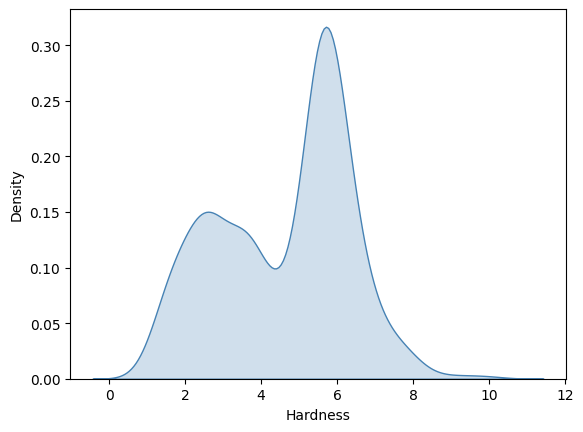

In [5]:
sns.kdeplot(data = df, x = 'Hardness', fill = True, color = 'steelblue');

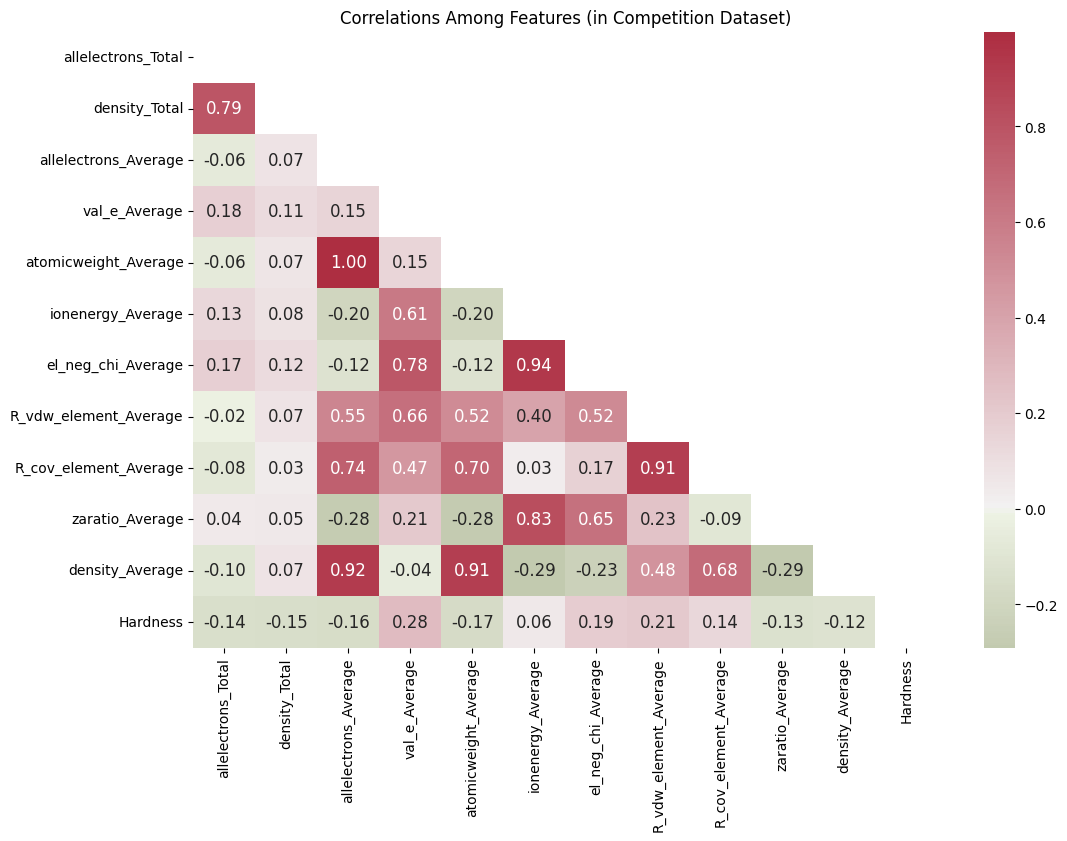

In [6]:
corr_mat_data = df.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Features (in Competition Dataset)');

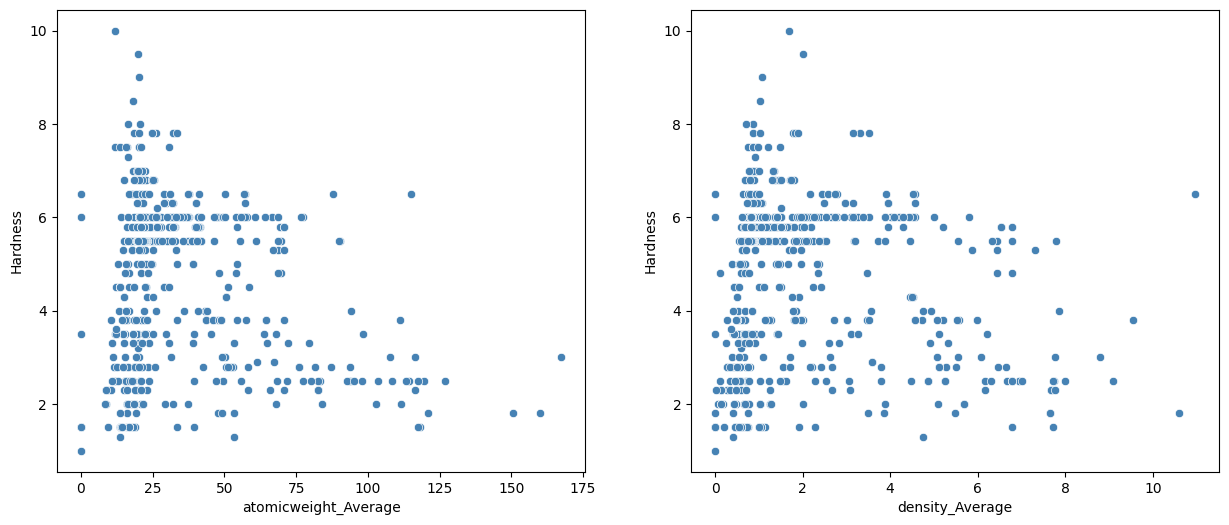

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = df, x = 'atomicweight_Average', y = 'Hardness', color = 'steelblue')
sns.scatterplot(ax = axes[1], data = df, x = 'density_Average', y = 'Hardness', color = 'steelblue');

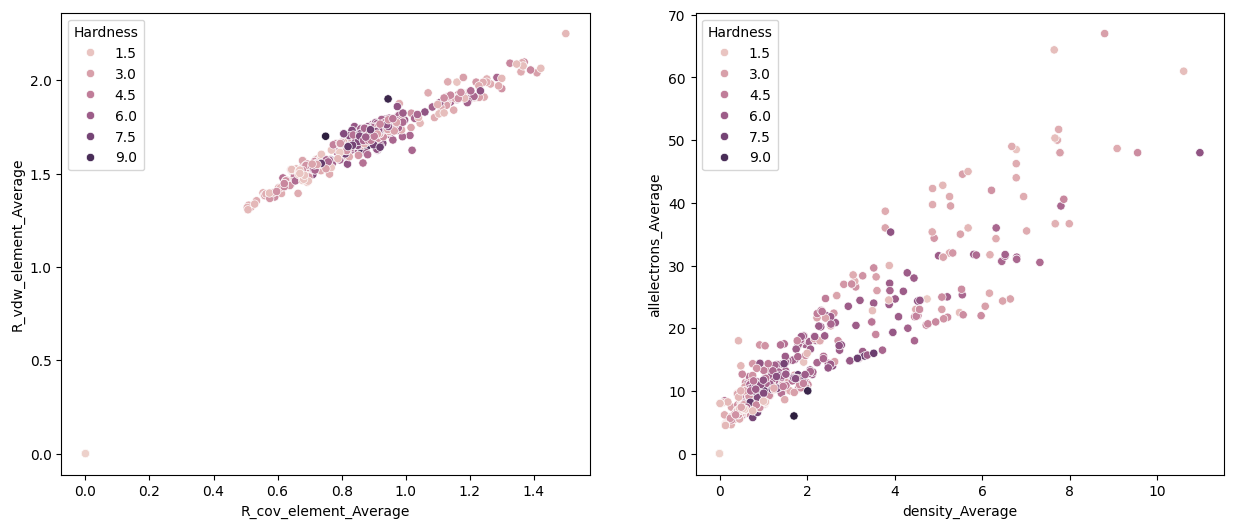

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(ax = axes[0], data = df, x = 'R_cov_element_Average', y = 'R_vdw_element_Average', hue = 'Hardness')
sns.scatterplot(ax = axes[1], data = df, x = 'density_Average', y = 'allelectrons_Average', hue = 'Hardness');

## PROCESAMIENTO DE DATOS

### SELECCIÓN DE CARACTERÍSTICAS

In [9]:
X = df.drop('Hardness', axis=1)
y = df['Hardness']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de regresión LASSO
lasso_model = Lasso(alpha=1.0)

# Entrenar el modelo
lasso_model.fit(X_train, y_train)

# Obtener los coeficientes no nulos (características seleccionadas)
selected_features = X.columns[lasso_model.coef_ != 0]

# Mostrar las características seleccionadas
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['allelectrons_Total', 'density_Total', 'atomicweight_Average'], dtype='object')


### OUTLIERS

In [10]:
df_columns_selected = df[selected_features]
k=1.8 
for i,column in enumerate(df_columns_selected,1):
  print(column)
  Q1 = np.quantile(df_columns_selected[column],0.25)
  Q3 = np.quantile(df_columns_selected[column],0.75)
  IQR = Q3 - Q1 
  xL=Q1 - k * IQR
  xU=Q3 + k * IQR
  print(f" Banda= [ {xL},{xU}]")
  outlaiers = 0
  for x in  range(len(df_columns_selected)):
          if df_columns_selected[column][x] < xL  or df_columns_selected[column][x]>xU:
               outlaiers +=1
            # print(f" El dato[{x}]={df_columns_selected[column][x]} es un outlier")
  print(f"Hay {outlaiers} outlaiers")

allelectrons_Total
 Banda= [ -426.9,915.15]
Hay 14 outlaiers
density_Total
 Banda= [ -33.11144520000001,78.49759120000002]
Hay 16 outlaiers
atomicweight_Average
 Banda= [ -17.20062643977206,74.8874043184249]
Hay 44 outlaiers


In [11]:
# Calcular el rango intercuartílico (IQR) para cada columna
Q1 = df_columns_selected[selected_features].quantile(0.25)
Q3 = df_columns_selected[selected_features].quantile(0.75)
IQR = Q3 - Q1
xL=Q1 - k * IQR
xU=Q3 + k * IQR

# Definir un filtro para eliminar outliers
filtro_outliers = ~((df_columns_selected[selected_features] < xL) | (df_columns_selected[selected_features] > xU)).any(axis=1)

# Aplicar el filtro para mantener solo los datos sin outliers
df_sin_outliers = df[filtro_outliers]

# Visualizar la diferencia de filas
outlaiers = df.shape[0]- df_sin_outliers.shape[0]

# Verificar la forma del DataFrame después de eliminar outliers
print(f'Forma del DataFrame antes de eliminar outliers: {df_columns_selected.shape}')
print(f'Forma del DataFrame después de eliminar outliers: {df_sin_outliers.shape}')
print(f'Se han eliminado {outlaiers} outliers')

Forma del DataFrame antes de eliminar outliers: (622, 3)
Forma del DataFrame después de eliminar outliers: (557, 12)
Se han eliminado 65 outliers


### NORMALIZACIÓN

In [12]:
column_names = df_sin_outliers.columns.values
index_to_remove = np.where(column_names == 'Hardness')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sin_outliers.drop('Hardness', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

## ENTRENAMIENTO

In [13]:
X = df_sin_outliers[selected_features]
y = df_sin_outliers['Hardness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SIN CROSS VALIDATION

In [14]:
model_sin_cross_val = LinearRegression()
model_sin_cross_val.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
predicciones_sin_cross_val = model_sin_cross_val.predict(X_test)

# Calcular el error cuadrático medio sin cross-validation
mse_sin_cv = mean_squared_error(y_test, predicciones_sin_cross_val)
print(f'Error cuadrático medio sin cross-validation: {mse_sin_cv}')

Error cuadrático medio sin cross-validation: 2.638260434322165


### CON CROSS VALIDATION

In [15]:
# Custom scoring function (MAE in this example)
def custom_scorer(y_true, y_pred):
    mae = median_absolute_error(y_true, y_pred)
    return mae

# Convert the custom scorer to a scorer compatible with cross_val_score
scorer = make_scorer(custom_scorer, greater_is_better=False)

skf = KFold(n_splits = 5)

model_con_cross_val = LinearRegression()
model_con_cross_val.fit(X, y)  # Ajustar el modelo con todos los datos
predicciones_con_cross_val = cross_val_score(model_con_cross_val, X, y, scoring=scorer, cv=skf, n_jobs=-1)
cv_mse = -np.mean(predicciones_con_cross_val)

print(f'Error cuadrático medio con cross-validation: {cv_mse}')

Error cuadrático medio con cross-validation: 1.194292125041649


### COMPARACIÓN

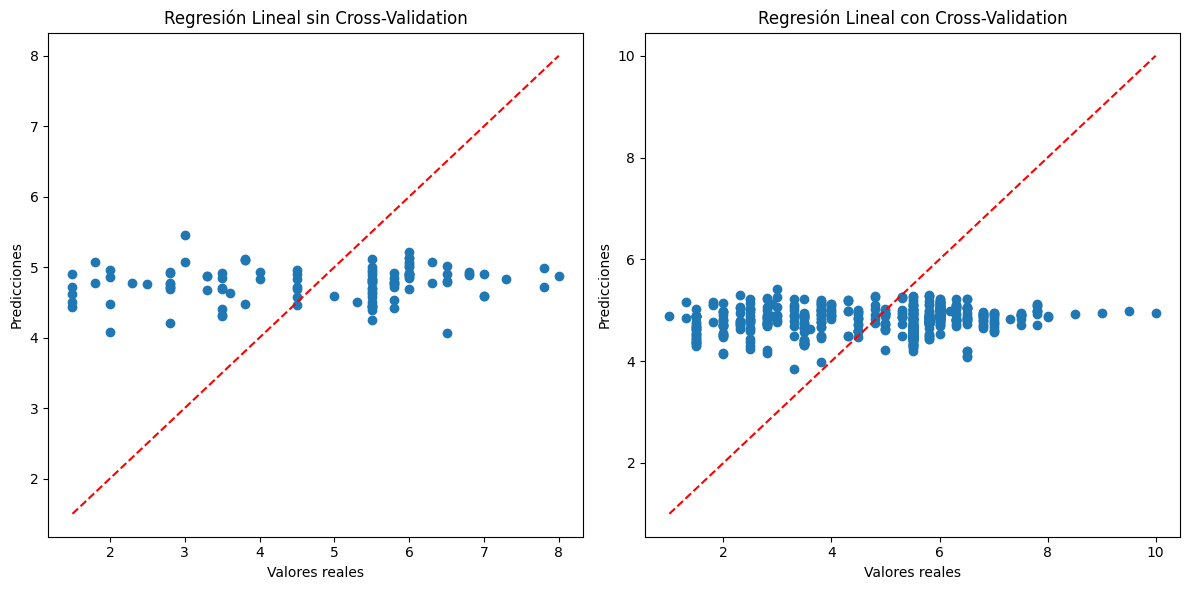

In [16]:
# Visualizar resultados
plt.figure(figsize=(12, 6))

# Gráfico para el modelo sin cross-validation
plt.subplot(1, 2, 1)
plt.scatter(y_test, predicciones_sin_cross_val)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Regresión Lineal sin Cross-Validation')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

# Gráfico para el modelo con cross-validation
plt.subplot(1, 2, 2)
plt.scatter(y, model_con_cross_val.predict(X))
plt.plot([min(y), max(y)], [min(y), max(y)], linestyle='--', color='red')
plt.title('Regresión Lineal con Cross-Validation')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()